In [1]:
import numpy as np
import pandas as pd
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import fastcluster
from scipy.cluster.hierarchy import fcluster

In [70]:
from matplotlib_venn import venn2, venn3

In [2]:
mixing_directory = 'maester_mixing'
mixing_quality_directory = 'maester_mixing_quality_based'
bp_directory = 'maester_bpdcn'
bp_quality_directory = 'maester_bpdcn_quaity_based'

In [65]:
metadata = pd.read_table('GSM5534702_K562-BT142_10x_scRNAseq_MetaData.txt')
metadata['barcode'] = metadata.index
metadata['barcode'] = metadata['barcode'].apply(lambda s: s.split("-")[0])
metadata

,orig.ident,nCount_RNA,nFeature_RNA,Well,CellType,UMAP_1,UMAP_2,decontX,barcode
ATGAGGGCAATAGTCC-1,TenX_CellLineMix,63330,7283,2,K562,-7.396740,-2.900096,0.007939,ATGAGGGCAATAGTCC
AGTACTGGTCAACCAT-1,TenX_CellLineMix,55614,6826,2,K562,-8.320074,-5.302868,0.006399,AGTACTGGTCAACCAT
CATCCACCAGTGTGCC-1,TenX_CellLineMix,51551,7135,2,K562,-5.008287,-4.201331,0.030149,CATCCACCAGTGTGCC
TATACCTAGTCCCTAA-1,TenX_CellLineMix,50588,6614,1,K562,-5.329810,-3.522900,0.006380,TATACCTAGTCCCTAA
TCCGATCGTGCAACGA-1,TenX_CellLineMix,50010,6646,2,K562,-8.647966,-6.690489,0.004746,TCCGATCGTGCAACGA
...,...,...,...,...,...,...,...,...,...
GTAGAAATCAGATTGC-1,TenX_CellLineMix,1526,1065,1,BT142,5.149190,1.583447,0.255933,GTAGAAATCAGATTGC
CTGTATTAGCCTTCTC-1,TenX_CellLineMix,1512,942,2,K562,-5.631015,-2.346343,0.008512,CTGTATTAGCCTTCTC
TCTCAGCGTCTAGTGT-1,TenX_CellLineMix,1282,955,1,BT142,6.077139,4.467698,0.041554,TCTCAGCGTCTAGTGT
GTGGGAAAGTTGGAAT-1,TenX_CellLineMix,1247,937,1,BT142,5.109194,1.938327,0.114183,GTGGGAAAGTTGGAAT


In [66]:
mixing_heteroplasmy = pd.read_csv(f'{mixing_directory}/final/final_variants_heteroplasmy_matrix.csv', index_col='variant')
mixing_quality_heteroplasmy = pd.read_csv(f'{mixing_quality_directory}/final/final_variants_heteroplasmy_matrix.csv', index_col='variant')


In [72]:
cell_set = set(mixing_heteroplasmy.columns)
quality_cell_set = set(mixing_quality_heteroplasmy.columns)
metadata_cell_set = set(metadata['barcode'])

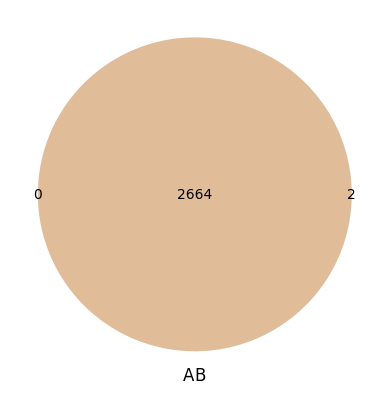

In [74]:
venn2([cell_set,metadata_cell_set])

In [75]:
cells_to_keep = set(metadata['barcode']).intersection(set(mixing_heteroplasmy.columns))
filtered_mixing_heteroplasmy = mixing_heteroplasmy[list(cells_to_keep)]
cells_to_keep = set(metadata['barcode']).intersection(set(mixing_quality_heteroplasmy.columns))
filtered_mixing_quality_heteroplasmy = mixing_quality_heteroplasmy[list(cells_to_keep)]

In [79]:
filtered_metadata = metadata[metadata['barcode'].isin(cells_to_keep)]

In [76]:
def compute_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2):
    return sum(sum(heteroplasmy_df.loc[rows_1][columns_2].values)
                   ) + sum(sum(mixing_heteroplasmy.loc[rows_2][columns_1].values))
def compute_relative_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2):
    contamination = compute_contamination(heteroplasmy_df, rows_1, rows_2, columns_1, columns_2)
    all_values = heteroplasmy_df.loc[rows_1+rows_2]
    return contamination/sum(sum(all_values.values))

In [80]:
known_variants = ['709_G_A', '1888_G_A', '1420_T_C', '2141_T_C', '9117_T_C', '7990_C_T']

k562 = list(filtered_metadata[filtered_metadata['CellType']=='K562']['barcode'])
bt142 = list(filtered_metadata[filtered_metadata['CellType']=='BT142']['barcode'])
k562_variants = ['709_G_A', '1888_G_A', '1420_T_C', '2141_T_C', '9117_T_C']
bt142_variants = ['7990_C_T']

In [81]:
contamination = compute_contamination(filtered_mixing_heteroplasmy,
                                      k562_variants, bt142_variants,
                                      k562, bt142)

In [83]:
relative_contamination  = compute_relative_contamination(filtered_mixing_heteroplasmy,
                                      k562_variants, bt142_variants,
                                      k562, bt142)

In [84]:
contamination_quality = compute_contamination(filtered_mixing_quality_heteroplasmy,
                                      k562_variants, bt142_variants,
                                      k562, bt142)
relative_contamination_quality  = compute_relative_contamination(filtered_mixing_quality_heteroplasmy,
                                      k562_variants, bt142_variants,
                                      k562, bt142)

Text(0, 0.5, 'Contamination')

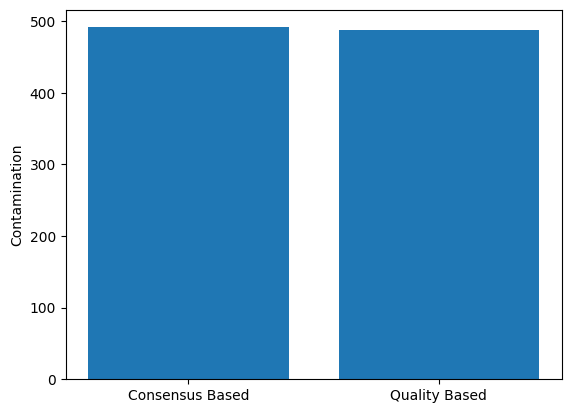

In [85]:
plt.bar(['Consensus Based', 'Quality Based'],[contamination, contamination_quality])
plt.ylabel('Contamination')

Text(0, 0.5, 'Contamination')

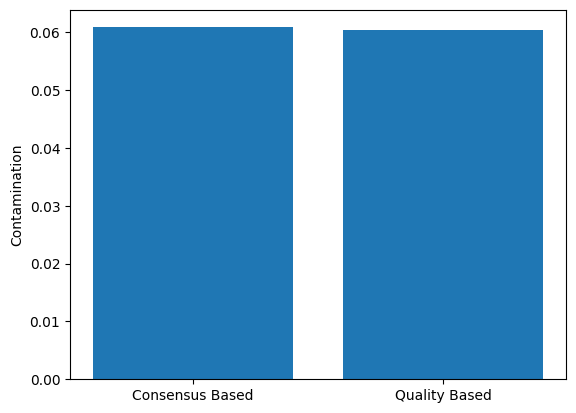

In [86]:
plt.bar(['Consensus Based', 'Quality Based'],[relative_contamination, relative_contamination_quality])
plt.ylabel('Contamination')

In [87]:
[contamination, contamination_quality]

[491.3598396259527, 488.2450627643097]

In [89]:
[relative_contamination, relative_contamination_quality]

[0.06088605412683808, 0.06043459334063119]

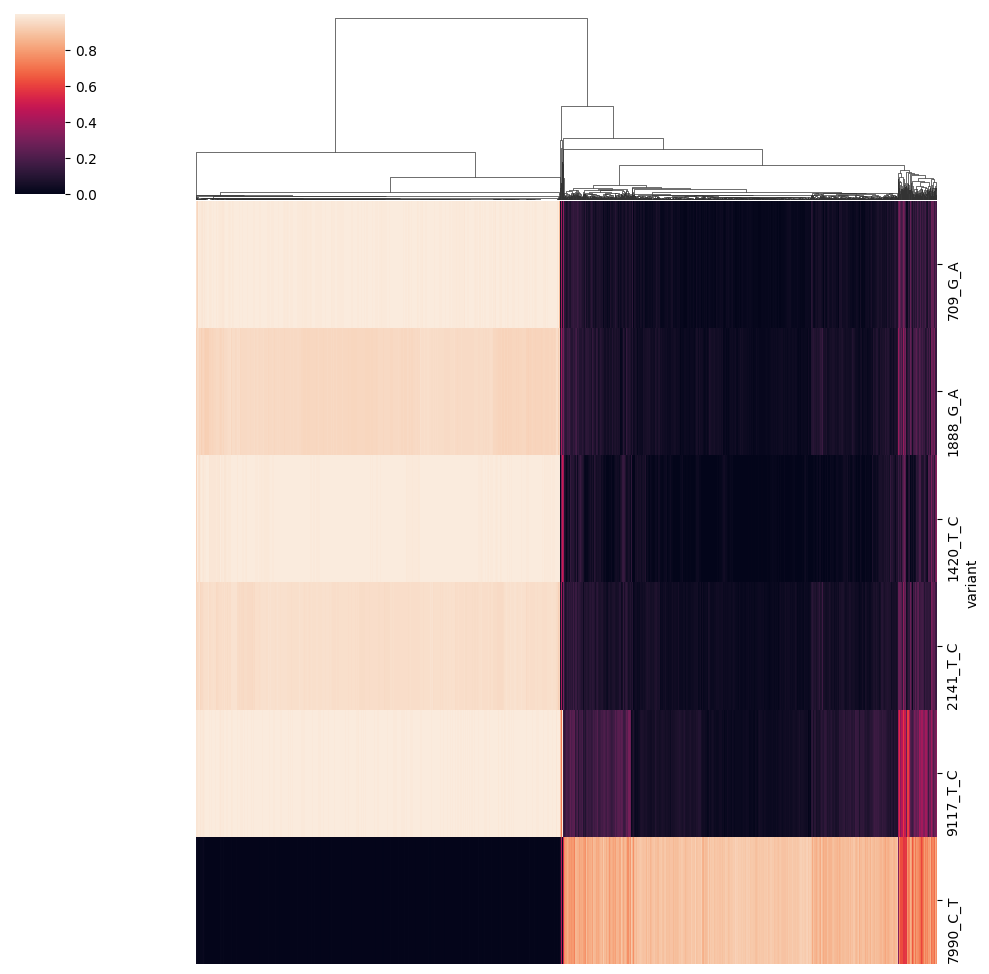

In [23]:
g=sns.clustermap(mixing_heteroplasmy.loc[known_variants],row_cluster=False,xticklabels=False)

In [24]:
col_clusters = fcluster(g.dendrogram_col.linkage, 2, criterion='maxclust')

In [42]:
first_columns  = [c for j,c in enumerate(mixing_heteroplasmy.loc[known_variants].columns) if col_clusters[j]==1]
second_columns  = [c for j,c in enumerate(mixing_heteroplasmy.loc[known_variants].columns) if col_clusters[j]==2]

In [43]:
first_variants = ['709_G_A', '1888_G_A', '1420_T_C', '2141_T_C', '9117_T_C']
second_variants = ['7990_C_T']

In [44]:
# define contamination as sum of heteroplasmy in off diagonal
contamination = compute_contamination(mixing_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns, second_columns)
contamination

482.1671163592688

In [45]:
relative_contamination  = compute_relative_contamination(mixing_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns, second_columns)
relative_contamination

0.05974695279772988

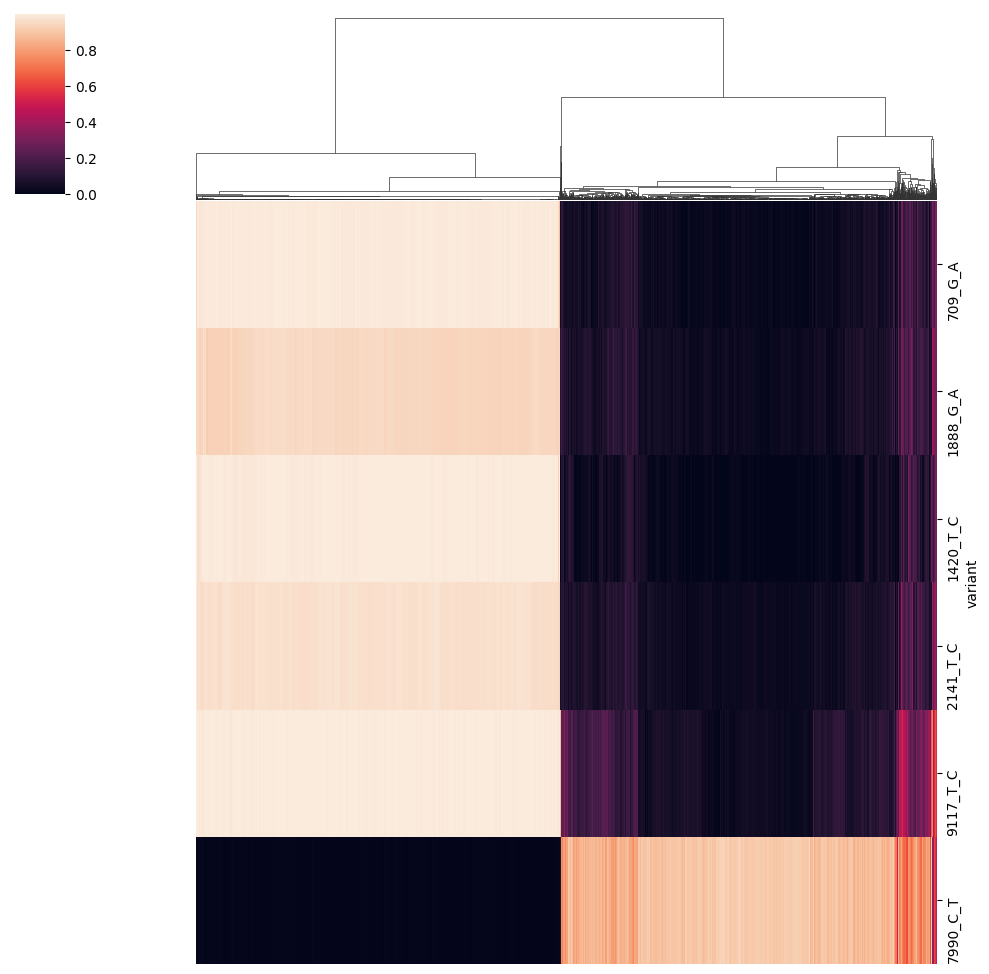

In [35]:
g2 = sns.clustermap(mixing_quality_heteroplasmy.loc[known_variants],row_cluster=False,xticklabels=False)

In [36]:
col_clusters2 = fcluster(g2.dendrogram_col.linkage, 2, criterion='maxclust')
np.shape(col_clusters2)

(2664,)

In [46]:
first_columns2  = [c for j,c in enumerate(mixing_quality_heteroplasmy.loc[known_variants].columns) if col_clusters2[j]==1]
second_columns2  = [c for j,c in enumerate(mixing_quality_heteroplasmy.loc[known_variants].columns) if col_clusters2[j]==2]


In [47]:
# define contamination as sum of heteroplasmy in off diagonal
contamination_quality = compute_contamination(mixing_quality_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns2, second_columns2)
contamination_quality

479.0460466541597

In [48]:
relative_contamination_quality  = compute_relative_contamination(mixing_quality_heteroplasmy,
                                      first_variants, second_variants,
                                      first_columns2, second_columns2)
relative_contamination_quality

0.059295946296044136

Text(0, 0.5, 'Contamination')

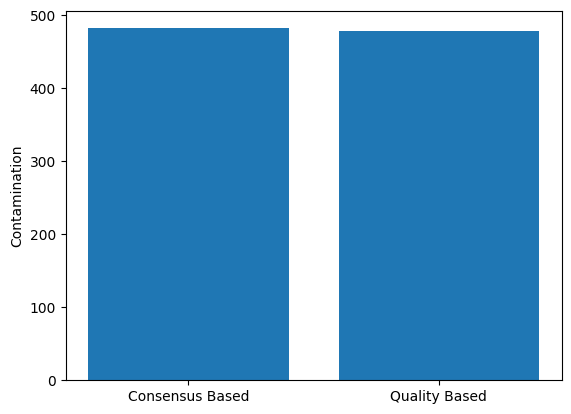

In [51]:
plt.bar(['Consensus Based', 'Quality Based'],[contamination, contamination_quality])
plt.ylabel('Contamination')

Text(0, 0.5, 'Contamination')

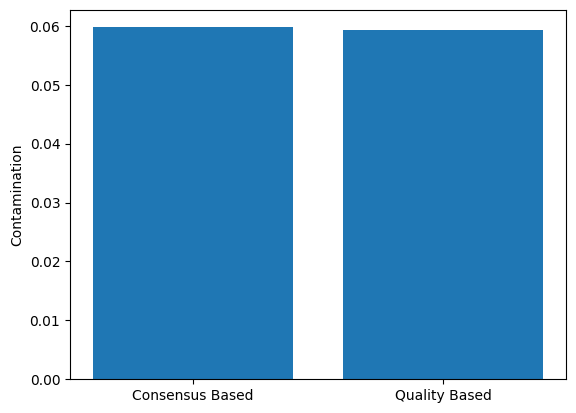

In [52]:
plt.bar(['Consensus Based', 'Quality Based'],[relative_contamination, relative_contamination_quality])
plt.ylabel('Contamination')